In [1]:
%pip install gdown
%pip install pyspark
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install seaborn
%pip install scikit-learn
%pip install scipy
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Fraud Detection Analysis") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/01 16:12:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
import os
import gdown

file_path = "../data/raw_data/Final Transaction.csv"

if not os.path.exists(file_path):
    url = "https://drive.google.com/file/d/1qJtOG4ReSYyaHn0xbitvXqESQS94OkqP/view?usp=drive_link"
    gdown.download(url, file_path, quiet=True, fuzzy=True)

df = spark.read.csv(file_path, header=True, inferSchema=True)
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- TRANSACTION_ID: integer (nullable = true)
 |-- TX_DATETIME: timestamp (nullable = true)
 |-- CUSTOMER_ID: integer (nullable = true)
 |-- TERMINAL_ID: integer (nullable = true)
 |-- TX_AMOUNT: double (nullable = true)
 |-- TX_TIME_SECONDS: integer (nullable = true)
 |-- TX_TIME_DAYS: integer (nullable = true)
 |-- TX_FRAUD: integer (nullable = true)
 |-- TX_FRAUD_SCENARIO: integer (nullable = true)



In [4]:
df.show(10)

+---+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|_c0|TRANSACTION_ID|        TX_DATETIME|CUSTOMER_ID|TERMINAL_ID|TX_AMOUNT|TX_TIME_SECONDS|TX_TIME_DAYS|TX_FRAUD|TX_FRAUD_SCENARIO|
+---+--------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|  0|             0|2023-01-01 00:00:31|        596|       3156|   533.07|             31|           0|       0|                0|
|  1|             1|2023-01-01 00:02:10|       4961|       3412|   808.56|            130|           0|       0|                0|
|  2|             2|2023-01-01 00:07:56|          2|       1365|  1442.94|            476|           0|       1|                1|
|  3|             3|2023-01-01 00:09:29|       4128|       8737|   620.65|            569|           0|       0|                0|
|  4|             4|2023-01-01 00:10:34|        927|       9906|   490.66|         

26/01/01 16:12:05 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , TRANSACTION_ID, TX_DATETIME, CUSTOMER_ID, TERMINAL_ID, TX_AMOUNT, TX_TIME_SECONDS, TX_TIME_DAYS, TX_FRAUD, TX_FRAUD_SCENARIO
 Schema: _c0, TRANSACTION_ID, TX_DATETIME, CUSTOMER_ID, TERMINAL_ID, TX_AMOUNT, TX_TIME_SECONDS, TX_TIME_DAYS, TX_FRAUD, TX_FRAUD_SCENARIO
Expected: _c0 but found: 
CSV file: file:///Users/bl-sw/code/Fraud-Detection-Kaggle/data/raw_data/Final%20Transaction.csv


In [5]:
remove_cols = ['_c0', 'TRANSACTION_ID', 'CUSTOMER_ID', 'TERMINAL_ID']
df = df.drop(*remove_cols)
df.show(5)

+-------------------+---------+---------------+------------+--------+-----------------+
|        TX_DATETIME|TX_AMOUNT|TX_TIME_SECONDS|TX_TIME_DAYS|TX_FRAUD|TX_FRAUD_SCENARIO|
+-------------------+---------+---------------+------------+--------+-----------------+
|2023-01-01 00:00:31|   533.07|             31|           0|       0|                0|
|2023-01-01 00:02:10|   808.56|            130|           0|       0|                0|
|2023-01-01 00:07:56|  1442.94|            476|           0|       1|                1|
|2023-01-01 00:09:29|   620.65|            569|           0|       0|                0|
|2023-01-01 00:10:34|   490.66|            634|           0|       0|                0|
+-------------------+---------+---------------+------------+--------+-----------------+
only showing top 5 rows


# Exploratory Data Analysis

## 1. Dataset Overview


In [6]:
print(df.describe())
df.printSchema()

DataFrame[summary: string, TX_AMOUNT: string, TX_TIME_SECONDS: string, TX_TIME_DAYS: string, TX_FRAUD: string, TX_FRAUD_SCENARIO: string]
root
 |-- TX_DATETIME: timestamp (nullable = true)
 |-- TX_AMOUNT: double (nullable = true)
 |-- TX_TIME_SECONDS: integer (nullable = true)
 |-- TX_TIME_DAYS: integer (nullable = true)
 |-- TX_FRAUD: integer (nullable = true)
 |-- TX_FRAUD_SCENARIO: integer (nullable = true)



In [7]:
numerical_cols = ['TX_AMOUNT']
categorical_cols = ['TX_FRAUD_SCENARIO']
target_cols = ['TX_FRAUD']
timestamp_cols = ['TX_DATETIME']
relative_time_cols = [
    "TX_TIME_SECONDS",
    "TX_TIME_DAYS"
]

## 2. Missing Values Check


In [8]:
from pyspark.sql.functions import col, isnan, count, when
from pyspark.sql.types import DoubleType, FloatType

exprs = []

for field in df.schema.fields:
    c = field.name
    dtype = field.dataType

    # Numeric → check NULL + NaN
    if isinstance(dtype, (DoubleType, FloatType)):
        exprs.append(
            count(
                when(col(c).isNull() | isnan(col(c)), c)
            ).alias(c)
        )
    # Non-numeric → chỉ check NULL
    else:
        exprs.append(
            count(
                when(col(c).isNull(), c)
            ).alias(c)
        )

missing_df = df.select(exprs)
missing_df.show(truncate=False)


+-----------+---------+---------------+------------+--------+-----------------+
|TX_DATETIME|TX_AMOUNT|TX_TIME_SECONDS|TX_TIME_DAYS|TX_FRAUD|TX_FRAUD_SCENARIO|
+-----------+---------+---------------+------------+--------+-----------------+
|0          |0        |0              |0           |0       |0                |
+-----------+---------+---------------+------------+--------+-----------------+



## 3. Descriptive Statistics


In [9]:
df.select(
    *numerical_cols,
    *target_cols,
    *categorical_cols,
    *timestamp_cols,
    *relative_time_cols
).describe().show()


26/01/01 16:12:05 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+-------------------+-------------------+-----------------+-----------------+
|summary|         TX_AMOUNT|           TX_FRAUD|  TX_FRAUD_SCENARIO|  TX_TIME_SECONDS|     TX_TIME_DAYS|
+-------+------------------+-------------------+-------------------+-----------------+-----------------+
|  count|           1754155|            1754155|            1754155|          1754155|          1754155|
|   mean|  539.681997280744| 0.1345200395632085|0.14497464591213433|7903233.708571933|90.97260276315377|
| stddev|1179.7105939984608|0.34121029423187604| 0.3874872015485641|4565172.383899659|52.83709109961424|
|    min|               0.0|                  0|                  0|               31|                0|
|    max|          647837.5|                  1|                  3|         15811197|              182|
+-------+------------------+-------------------+-------------------+-----------------+-----------------+



## 4. Target Variable Distribution (TX_FRAUD)


In [10]:
total = df.count()

fraud_dist = (
    df.groupBy("TX_FRAUD")
      .count()
      .withColumn("ratio", col("count") / total * 100)
      .orderBy("TX_FRAUD")
)

fraud_dist.show(truncate=False)


+--------+-------+-----------------+
|TX_FRAUD|count  |ratio            |
+--------+-------+-----------------+
|0       |1518186|86.54799604367915|
|1       |235969 |13.45200395632085|
+--------+-------+-----------------+



## 5. Important Features Analysis

### 5.1. TX_AMOUNT Analysis (Transaction Amount)


TX_AMOUNT ANALYSIS BY TX_FRAUD
+--------+------------------+------------------+----------+----------+-------+
|TX_FRAUD|mean_amount       |stddev_amount     |min_amount|max_amount|count  |
+--------+------------------+------------------+----------+----------+-------+
|0       |393.90920306207437|275.34467418810556|0.0       |1000.0    |1518186|
|1       |1477.5603430111585|2973.50249720581  |0.2       |647837.5  |235969 |
+--------+------------------+------------------+----------+----------+-------+


Detailed statistics:

Non-Fraud:
  Mean:    393.91
  StdDev:  275.34
  Min:     0.00
  Max:     1000.00
  Count:   1,518,186

Fraud:
  Mean:    1477.56
  StdDev:  2973.50
  Min:     0.20
  Max:     647837.50
  Count:   235,969


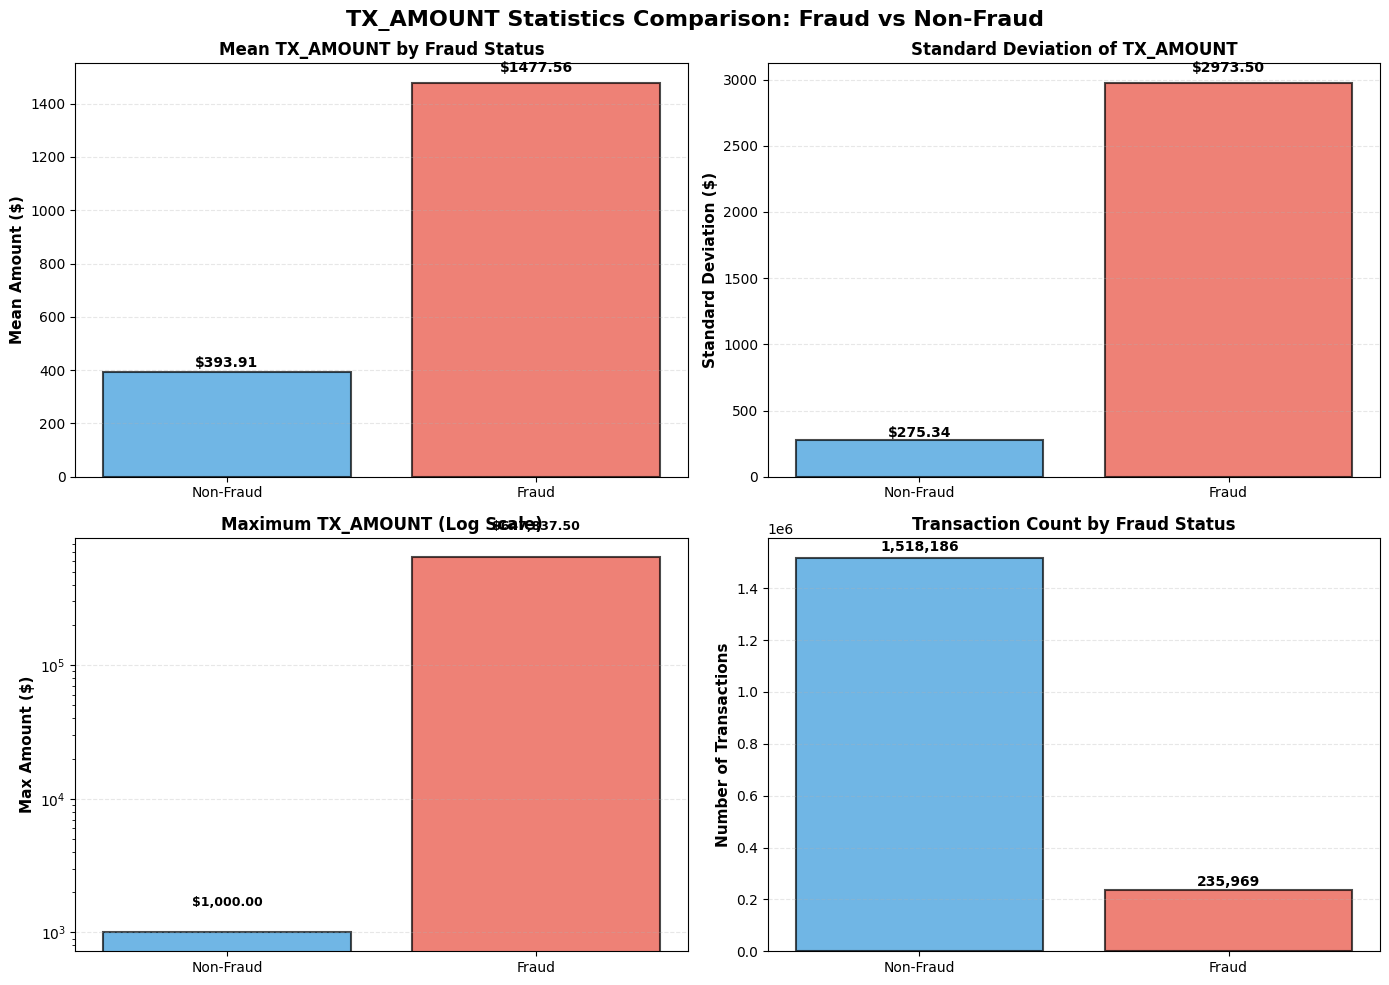

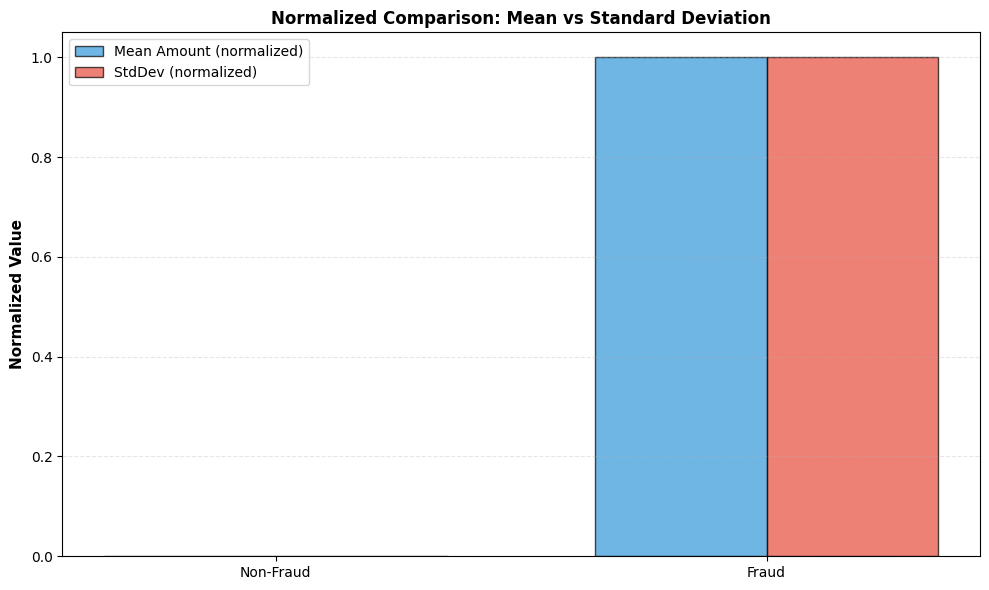

In [21]:
from pyspark.sql.functions import col, mean, stddev, min as spark_min, max as spark_max, count

print("=" * 60)
print("TX_AMOUNT ANALYSIS BY TX_FRAUD")
print("=" * 60)

amount_stats = (
    df.groupBy("TX_FRAUD")
      .agg(
          mean("TX_AMOUNT").alias("mean_amount"),
          stddev("TX_AMOUNT").alias("stddev_amount"),
          spark_min("TX_AMOUNT").alias("min_amount"),
          spark_max("TX_AMOUNT").alias("max_amount"),
          count("*").alias("count")
      )
      .orderBy("TX_FRAUD")
)


amount_stats.show(truncate=False)

# Display detailed statistics
print("\nDetailed statistics:")
for row in amount_stats.collect():
    fraud_label = "Fraud" if row['TX_FRAUD'] == 1 else "Non-Fraud"
    print(f"\n{fraud_label}:")
    print(f"  Mean:    {row['mean_amount']:.2f}")
    print(f"  StdDev:  {row['stddev_amount']:.2f}")
    print(f"  Min:     {row['min_amount']:.2f}")
    print(f"  Max:     {row['max_amount']:.2f}")
    print(f"  Count:   {row['count']:,}")

# Visualization
import matplotlib.pyplot as plt
import numpy as np

# Convert to Pandas for visualization
stats_pd = amount_stats.toPandas()
stats_pd['TX_FRAUD'] = stats_pd['TX_FRAUD'].map({0: 'Non-Fraud', 1: 'Fraud'})

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('TX_AMOUNT Statistics Comparison: Fraud vs Non-Fraud', fontsize=16, fontweight='bold')

# 1. Mean Amount Comparison
ax1 = axes[0, 0]
bars1 = ax1.bar(stats_pd['TX_FRAUD'], stats_pd['mean_amount'], 
                color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Mean Amount ($)', fontsize=11, fontweight='bold')
ax1.set_title('Mean TX_AMOUNT by Fraud Status', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars1, stats_pd['mean_amount'])):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + val*0.02,
             f'${val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 2. Standard Deviation Comparison
ax2 = axes[0, 1]
bars2 = ax2.bar(stats_pd['TX_FRAUD'], stats_pd['stddev_amount'], 
                color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Standard Deviation ($)', fontsize=11, fontweight='bold')
ax2.set_title('Standard Deviation of TX_AMOUNT', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars2, stats_pd['stddev_amount'])):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + val*0.02,
             f'${val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 3. Max Amount Comparison (log scale due to large difference)
ax3 = axes[1, 0]
bars3 = ax3.bar(stats_pd['TX_FRAUD'], stats_pd['max_amount'], 
                color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Max Amount ($)', fontsize=11, fontweight='bold')
ax3.set_title('Maximum TX_AMOUNT (Log Scale)', fontsize=12, fontweight='bold')
ax3.set_yscale('log')
ax3.grid(axis='y', alpha=0.3, linestyle='--')
# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars3, stats_pd['max_amount'])):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.5,
             f'${val:,.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 4. Count Comparison
ax4 = axes[1, 1]
bars4 = ax4.bar(stats_pd['TX_FRAUD'], stats_pd['count'], 
                color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Number of Transactions', fontsize=11, fontweight='bold')
ax4.set_title('Transaction Count by Fraud Status', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3, linestyle='--')
# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars4, stats_pd['count'])):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + val*0.01,
             f'{val:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Additional: Side-by-side comparison chart
fig2, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(stats_pd))
width = 0.35

# Normalize mean and stddev for better comparison (using min-max scaling)
mean_normalized = (stats_pd['mean_amount'] - stats_pd['mean_amount'].min()) / (stats_pd['mean_amount'].max() - stats_pd['mean_amount'].min())
stddev_normalized = (stats_pd['stddev_amount'] - stats_pd['stddev_amount'].min()) / (stats_pd['stddev_amount'].max() - stats_pd['stddev_amount'].min())

bars1 = ax.bar(x - width/2, mean_normalized, width, label='Mean Amount (normalized)', 
               color='#3498db', alpha=0.7, edgecolor='black')
bars2 = ax.bar(x + width/2, stddev_normalized, width, label='StdDev (normalized)', 
               color='#e74c3c', alpha=0.7, edgecolor='black')

ax.set_ylabel('Normalized Value', fontsize=11, fontweight='bold')
ax.set_title('Normalized Comparison: Mean vs Standard Deviation', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(stats_pd['TX_FRAUD'])
ax.legend()
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()



In [12]:
sample_df = (
    df.select("TX_AMOUNT", "TX_FRAUD")
      .sampleBy(
          "TX_FRAUD",
          fractions={0: 0.01, 1: 0.05},  # non-fraud ít, fraud nhiều
          seed=42
      )
      .toPandas()
)


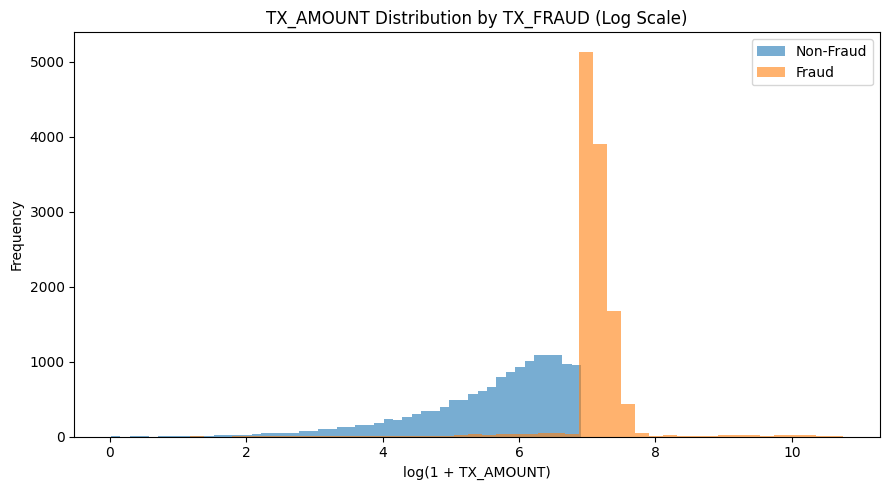

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(9,5))

for label, name in [(0, "Non-Fraud"), (1, "Fraud")]:
    subset = sample_df[sample_df["TX_FRAUD"] == label]["TX_AMOUNT"]
    plt.hist(
        np.log1p(subset),
        bins=50,
        alpha=0.6,
        label=name
    )

plt.xlabel("log(1 + TX_AMOUNT)")
plt.ylabel("Frequency")
plt.title("TX_AMOUNT Distribution by TX_FRAUD (Log Scale)")
plt.legend()
plt.tight_layout()
plt.show()


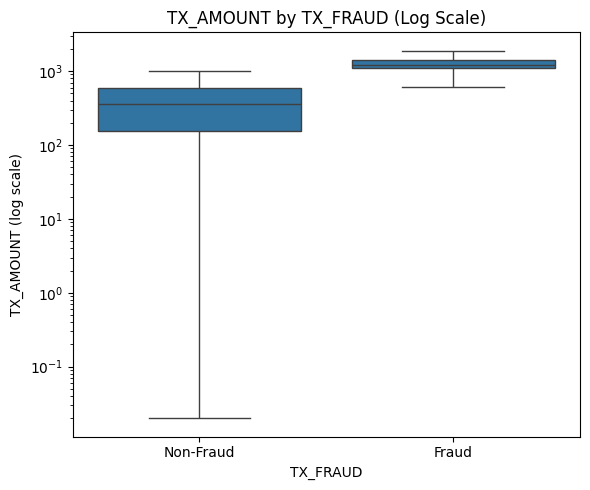

In [14]:
import seaborn as sns

plt.figure(figsize=(6,5))

sns.boxplot(
    x="TX_FRAUD",
    y="TX_AMOUNT",
    data=sample_df,
    showfliers=False
)

plt.yscale("log")
plt.xticks([0,1], ["Non-Fraud", "Fraud"])
plt.ylabel("TX_AMOUNT (log scale)")
plt.title("TX_AMOUNT by TX_FRAUD (Log Scale)")
plt.tight_layout()
plt.show()


### 5.3. Time-based Analysis


TIME-BASED ANALYSIS

Time range:
  Start date: 2023-01-01
  End date: 2023-07-02

Top 10 days with most transactions:
+----------+--------+--------+
|TX_DATE   |total_tx|fraud_tx|
+----------+--------+--------+
|2023-04-01|9789    |1295    |
|2023-04-27|9787    |1344    |
|2023-04-06|9784    |1313    |
|2023-02-02|9771    |1414    |
|2023-02-15|9767    |1319    |
|2023-06-11|9762    |1367    |
|2023-01-30|9760    |1244    |
|2023-01-13|9753    |1349    |
|2023-02-09|9749    |1312    |
|2023-01-03|9747    |1309    |
+----------+--------+--------+


Transaction distribution by hour of day:
+-------+--------+--------+
|TX_HOUR|total_tx|fraud_tx|
+-------+--------+--------+
|0      |15137   |2031    |
|1      |21861   |2968    |
|2      |30140   |4051    |
|3      |40380   |5306    |
|4      |52403   |6887    |
|5      |65168   |8811    |
|6      |79880   |10925   |
|7      |94030   |12795   |
|8      |106617  |14411   |
|9      |116864  |15573   |
|10     |125804  |16793   |
|11     |1289

/var/folders/v4/nwlxxbxx0l93n7y5mpfv8yhw0000gn/T/ipykernel_14631/1253489110.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


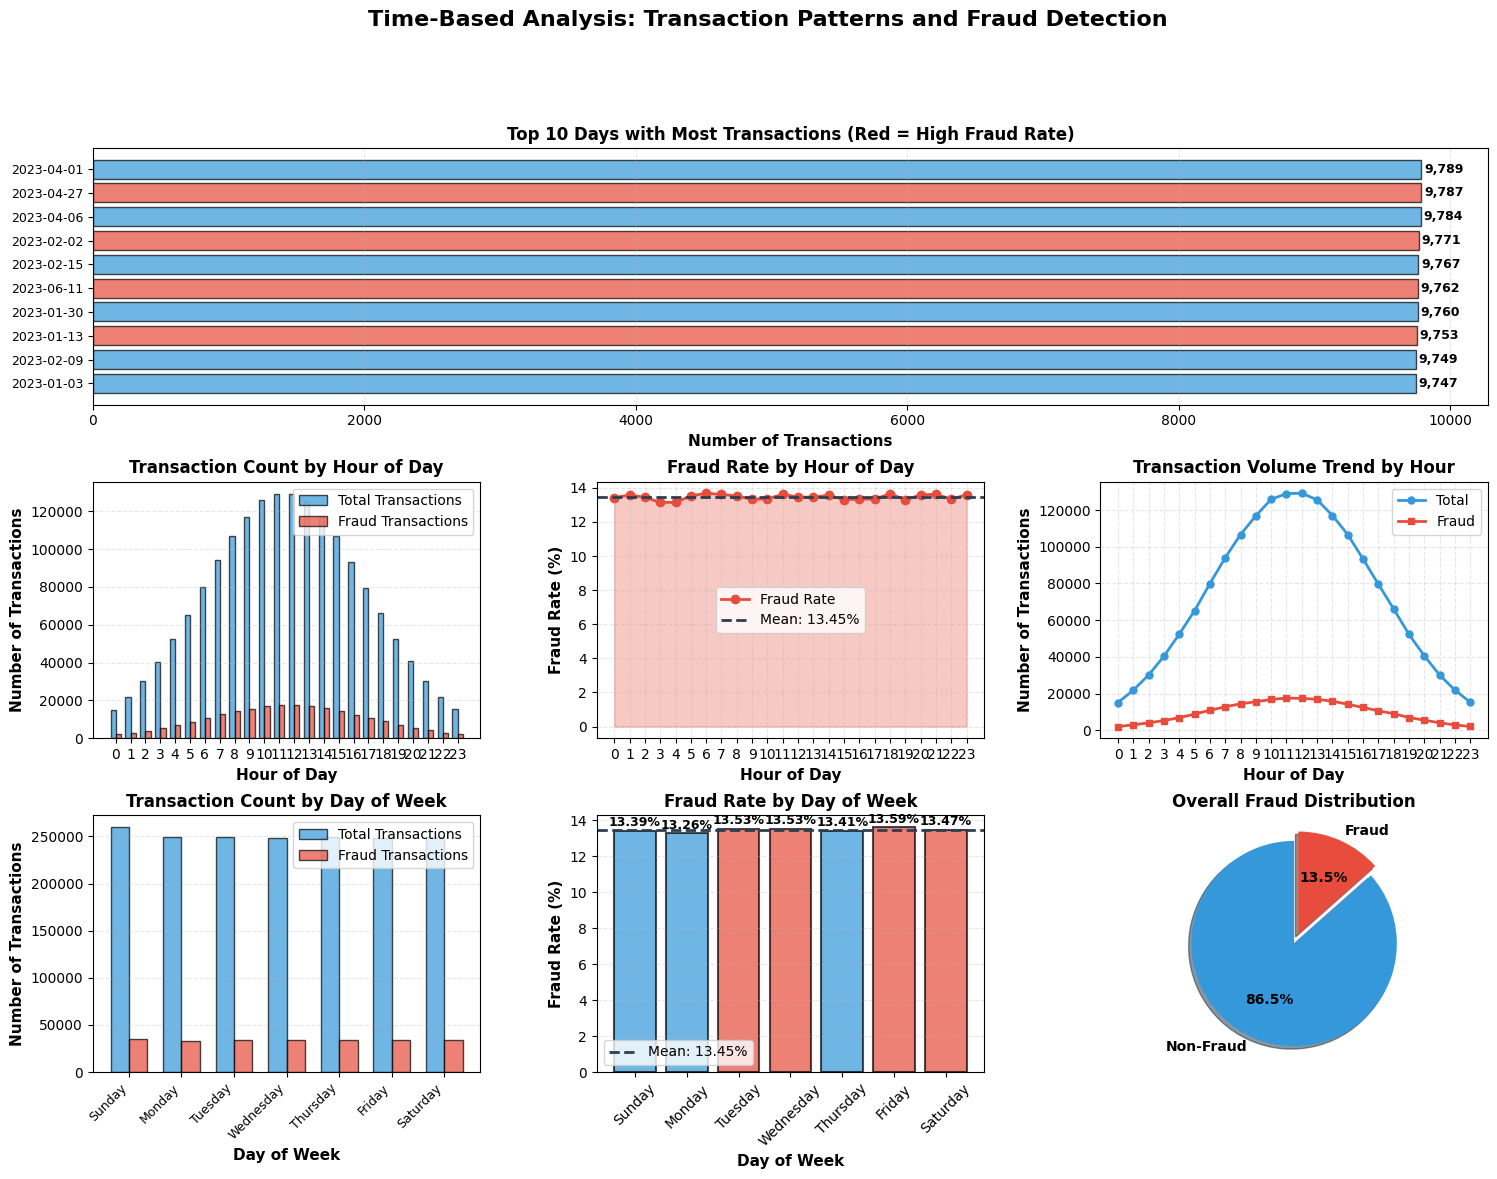

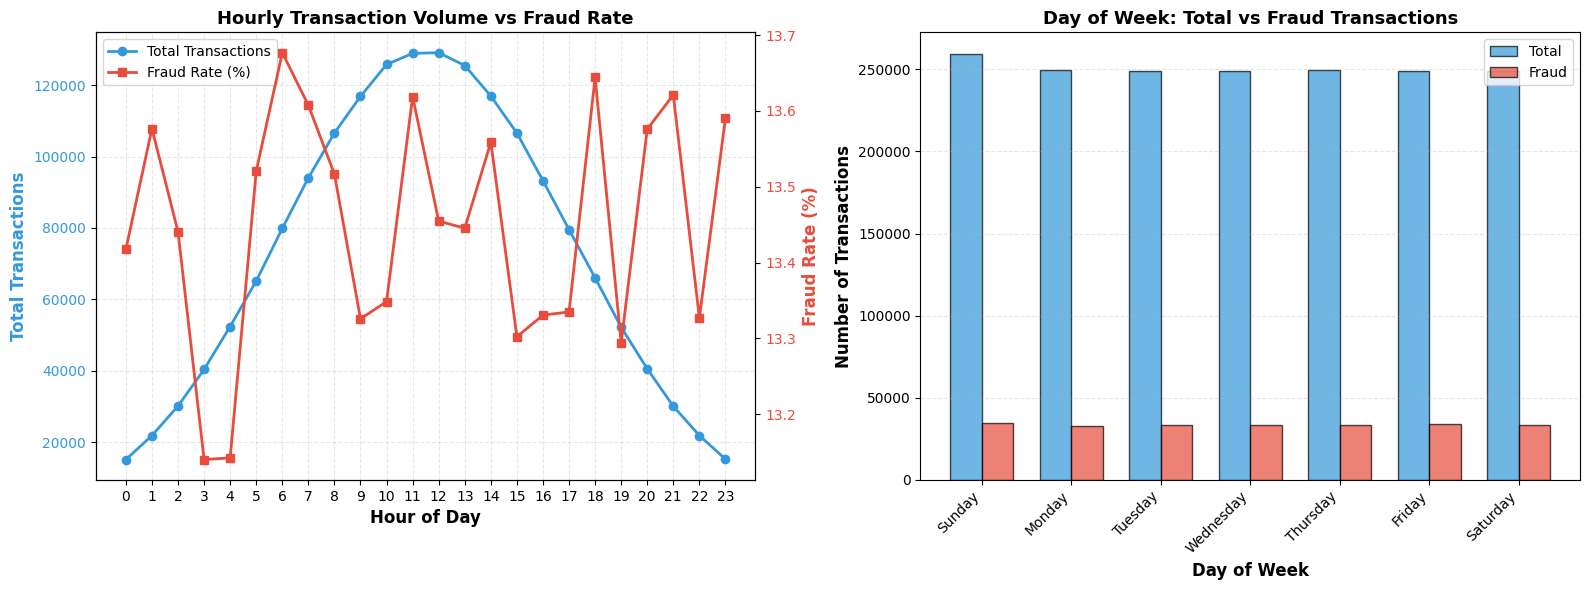

In [22]:
from pyspark.sql.functions import to_date, hour, dayofweek, count as spark_count, col, when, min as spark_min, max as spark_max

print("=" * 60)
print("TIME-BASED ANALYSIS")
print("=" * 60)

# Convert TX_DATETIME to date and extract time features
df_time = df.withColumn("TX_DATE", to_date("TX_DATETIME")) \
            .withColumn("TX_HOUR", hour("TX_DATETIME")) \
            .withColumn("TX_DAYOFWEEK", dayofweek("TX_DATETIME"))

# Time range of the dataset
date_range = df_time.select(
    spark_min("TX_DATE").alias("min_date"),
    spark_max("TX_DATE").alias("max_date")
).collect()[0]

print(f"\nTime range:")
print(f"  Start date: {date_range['min_date']}")
print(f"  End date: {date_range['max_date']}")

# Transaction distribution by day
print("\nTop 10 days with most transactions:")
daily_tx = df_time.groupBy("TX_DATE").agg(
    spark_count("*").alias("total_tx"),
    spark_count(when(col("TX_FRAUD") == 1, 1)).alias("fraud_tx")
).orderBy(col("total_tx").desc()).limit(10)
daily_tx.show(truncate=False)

# Transaction distribution by hour
print("\nTransaction distribution by hour of day:")
hourly_tx = df_time.groupBy("TX_HOUR").agg(
    spark_count("*").alias("total_tx"),
    spark_count(when(col("TX_FRAUD") == 1, 1)).alias("fraud_tx")
).orderBy("TX_HOUR")
hourly_tx.show(24, truncate=False)

# Transaction distribution by day of week
print("\nTransaction distribution by day of week:")
# 1 = Sunday, 2 = Monday, ..., 7 = Saturday
day_names = {1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday", 
             5: "Thursday", 6: "Friday", 7: "Saturday"}
dow_tx = df_time.groupBy("TX_DAYOFWEEK").agg(
    spark_count("*").alias("total_tx"),
    spark_count(when(col("TX_FRAUD") == 1, 1)).alias("fraud_tx")
).orderBy("TX_DAYOFWEEK")

print("Day        | Total Transactions | Fraud Transactions")
print("-" * 50)
for row in dow_tx.collect():
    day_name = day_names.get(row['TX_DAYOFWEEK'], f"Day {row['TX_DAYOFWEEK']}")
    print(f"{day_name:10s} | {row['total_tx']:>15,} | {row['fraud_tx']:>15,}")

# ============================================
# VISUALIZATIONS
# ============================================
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime

# Convert to Pandas for visualization
daily_pd = daily_tx.toPandas()
hourly_pd = hourly_tx.toPandas()
dow_pd = dow_tx.toPandas()

# Calculate fraud rates
hourly_pd["fraud_rate"] = hourly_pd["fraud_tx"] / hourly_pd["total_tx"] * 100
dow_pd["fraud_rate"] = dow_pd["fraud_tx"] / dow_pd["total_tx"] * 100
daily_pd["fraud_rate"] = daily_pd["fraud_tx"] / daily_pd["total_tx"] * 100

# Sort day of week data properly
dow_pd = dow_pd.sort_values("TX_DAYOFWEEK")
dow_pd["day_name"] = dow_pd["TX_DAYOFWEEK"].map(day_names)

# Create comprehensive visualization figure
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Top 10 Days with Most Transactions
ax1 = fig.add_subplot(gs[0, :])
daily_pd_sorted = daily_pd.sort_values("total_tx", ascending=True)
colors_bar = ['#e74c3c' if rate > daily_pd["fraud_rate"].mean() else '#3498db' 
              for rate in daily_pd_sorted["fraud_rate"]]
bars = ax1.barh(range(len(daily_pd_sorted)), daily_pd_sorted["total_tx"], 
                color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1)
ax1.set_yticks(range(len(daily_pd_sorted)))
ax1.set_yticklabels([str(date)[:10] for date in daily_pd_sorted["TX_DATE"]], fontsize=9)
ax1.set_xlabel('Number of Transactions', fontsize=11, fontweight='bold')
ax1.set_title('Top 10 Days with Most Transactions (Red = High Fraud Rate)', 
              fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3, linestyle='--')
# Add value labels
for i, (bar, val) in enumerate(zip(bars, daily_pd_sorted["total_tx"])):
    ax1.text(bar.get_width() + 20, bar.get_y() + bar.get_height()/2,
             f'{int(val):,}', ha='left', va='center', fontweight='bold', fontsize=9)

# 2. Transaction Distribution by Hour (Total vs Fraud)
ax2 = fig.add_subplot(gs[1, 0])
x_pos = hourly_pd["TX_HOUR"]
width = 0.35
bars1 = ax2.bar(x_pos - width/2, hourly_pd["total_tx"], width, 
                label='Total Transactions', color='#3498db', alpha=0.7, edgecolor='black')
bars2 = ax2.bar(x_pos + width/2, hourly_pd["fraud_tx"], width,
                label='Fraud Transactions', color='#e74c3c', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Hour of Day', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of Transactions', fontsize=11, fontweight='bold')
ax2.set_title('Transaction Count by Hour of Day', fontsize=12, fontweight='bold')
ax2.set_xticks(range(0, 24))
ax2.legend()
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# 3. Fraud Rate by Hour
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(hourly_pd["TX_HOUR"], hourly_pd["fraud_rate"], 
         marker='o', linewidth=2, markersize=6, color='#e74c3c', label='Fraud Rate')
ax3.fill_between(hourly_pd["TX_HOUR"], hourly_pd["fraud_rate"], 
                 alpha=0.3, color='#e74c3c')
ax3.axhline(y=hourly_pd["fraud_rate"].mean(), color='#2c3e50', 
           linestyle='--', linewidth=2, label=f'Mean: {hourly_pd["fraud_rate"].mean():.2f}%')
ax3.set_xlabel('Hour of Day', fontsize=11, fontweight='bold')
ax3.set_ylabel('Fraud Rate (%)', fontsize=11, fontweight='bold')
ax3.set_title('Fraud Rate by Hour of Day', fontsize=12, fontweight='bold')
ax3.set_xticks(range(0, 24))
ax3.legend()
ax3.grid(True, alpha=0.3, linestyle='--')

# 4. Transaction Volume by Hour (Line chart)
ax4 = fig.add_subplot(gs[1, 2])
ax4.plot(hourly_pd["TX_HOUR"], hourly_pd["total_tx"], 
         marker='o', linewidth=2, markersize=5, color='#3498db', label='Total')
ax4.plot(hourly_pd["TX_HOUR"], hourly_pd["fraud_tx"], 
         marker='s', linewidth=2, markersize=5, color='#e74c3c', label='Fraud')
ax4.set_xlabel('Hour of Day', fontsize=11, fontweight='bold')
ax4.set_ylabel('Number of Transactions', fontsize=11, fontweight='bold')
ax4.set_title('Transaction Volume Trend by Hour', fontsize=12, fontweight='bold')
ax4.set_xticks(range(0, 24))
ax4.legend()
ax4.grid(True, alpha=0.3, linestyle='--')

# 5. Transaction Distribution by Day of Week (Bar chart)
ax5 = fig.add_subplot(gs[2, 0])
x_pos_dow = np.arange(len(dow_pd))
bars1_dow = ax5.bar(x_pos_dow - width/2, dow_pd["total_tx"], width,
                    label='Total Transactions', color='#3498db', alpha=0.7, edgecolor='black')
bars2_dow = ax5.bar(x_pos_dow + width/2, dow_pd["fraud_tx"], width,
                    label='Fraud Transactions', color='#e74c3c', alpha=0.7, edgecolor='black')
ax5.set_xlabel('Day of Week', fontsize=11, fontweight='bold')
ax5.set_ylabel('Number of Transactions', fontsize=11, fontweight='bold')
ax5.set_title('Transaction Count by Day of Week', fontsize=12, fontweight='bold')
ax5.set_xticks(x_pos_dow)
ax5.set_xticklabels(dow_pd["day_name"], rotation=45, ha='right', fontsize=9)
ax5.legend()
ax5.grid(axis='y', alpha=0.3, linestyle='--')

# 6. Fraud Rate by Day of Week
ax6 = fig.add_subplot(gs[2, 1])
bars_fraud_rate = ax6.bar(dow_pd["day_name"], dow_pd["fraud_rate"],
                          color=['#e74c3c' if rate > dow_pd["fraud_rate"].mean() else '#3498db' 
                                 for rate in dow_pd["fraud_rate"]],
                          alpha=0.7, edgecolor='black', linewidth=1.5)
ax6.axhline(y=dow_pd["fraud_rate"].mean(), color='#2c3e50', 
           linestyle='--', linewidth=2, label=f'Mean: {dow_pd["fraud_rate"].mean():.2f}%')
ax6.set_xlabel('Day of Week', fontsize=11, fontweight='bold')
ax6.set_ylabel('Fraud Rate (%)', fontsize=11, fontweight='bold')
ax6.set_title('Fraud Rate by Day of Week', fontsize=12, fontweight='bold')
ax6.tick_params(axis='x', rotation=45)
ax6.legend()
ax6.grid(axis='y', alpha=0.3, linestyle='--')
# Add value labels
for bar, val in zip(bars_fraud_rate, dow_pd["fraud_rate"]):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{val:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 7. Heatmap: Hour vs Day of Week (if we have the data)
# For now, show a summary pie chart of fraud distribution
ax7 = fig.add_subplot(gs[2, 2])
total_fraud = dow_pd["fraud_tx"].sum()
total_non_fraud = dow_pd["total_tx"].sum() - total_fraud
colors_pie = ['#3498db', '#e74c3c']
ax7.pie([total_non_fraud, total_fraud], 
        labels=['Non-Fraud', 'Fraud'],
        autopct='%1.1f%%',
        startangle=90,
        colors=colors_pie,
        explode=(0, 0.1),
        shadow=True,
        textprops={'fontsize': 10, 'fontweight': 'bold'})
ax7.set_title('Overall Fraud Distribution', fontsize=12, fontweight='bold')

plt.suptitle('Time-Based Analysis: Transaction Patterns and Fraud Detection', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Additional: Detailed Hourly Analysis
fig2, (ax8, ax9) = plt.subplots(1, 2, figsize=(16, 6))

# Hourly transaction volume with fraud overlay
ax8_twin = ax8.twinx()
line1 = ax8.plot(hourly_pd["TX_HOUR"], hourly_pd["total_tx"], 
                 'o-', color='#3498db', linewidth=2, markersize=6, label='Total Transactions')
line2 = ax8_twin.plot(hourly_pd["TX_HOUR"], hourly_pd["fraud_rate"], 
                      's-', color='#e74c3c', linewidth=2, markersize=6, label='Fraud Rate (%)')
ax8.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
ax8.set_ylabel('Total Transactions', fontsize=12, fontweight='bold', color='#3498db')
ax8_twin.set_ylabel('Fraud Rate (%)', fontsize=12, fontweight='bold', color='#e74c3c')
ax8.set_title('Hourly Transaction Volume vs Fraud Rate', fontsize=13, fontweight='bold')
ax8.set_xticks(range(0, 24))
ax8.tick_params(axis='y', labelcolor='#3498db')
ax8_twin.tick_params(axis='y', labelcolor='#e74c3c')
ax8.grid(True, alpha=0.3, linestyle='--')
# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax8.legend(lines, labels, loc='upper left')

# Day of Week comparison
ax9.bar(x_pos_dow - width/2, dow_pd["total_tx"], width,
        label='Total', color='#3498db', alpha=0.7, edgecolor='black')
ax9.bar(x_pos_dow + width/2, dow_pd["fraud_tx"], width,
        label='Fraud', color='#e74c3c', alpha=0.7, edgecolor='black')
ax9.set_xlabel('Day of Week', fontsize=12, fontweight='bold')
ax9.set_ylabel('Number of Transactions', fontsize=12, fontweight='bold')
ax9.set_title('Day of Week: Total vs Fraud Transactions', fontsize=13, fontweight='bold')
ax9.set_xticks(x_pos_dow)
ax9.set_xticklabels(dow_pd["day_name"], rotation=45, ha='right')
ax9.legend()
ax9.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


## Time-Based Feature Analysis: Hour vs Day-of-Week

### Hour of Day
Analysis by hour of day shows small but consistent variations in fraud rate throughout the day.  
Although the overall fraud rate remains relatively stable (~13.4–13.6%), certain hours exhibit slightly higher or lower risk.

**Key observations:**
- Fraud rate is not flat across hours, indicating weak but consistent temporal patterns.
- Variations are subtle rather than dramatic, suggesting that hour-of-day is not a strong standalone predictor.
- However, these patterns can provide valuable contextual signals when combined with other features such as transaction amount.

**Conclusion:**  
Hour-of-day features are useful as **secondary contextual features**, particularly for tree-based models that can capture non-linear interactions (e.g., amount × time).

---

### Day of Week
Fraud rate by day of week shows minimal variation, with differences across days remaining below 0.3% in absolute terms.

**Key observations:**
- Transaction volume is evenly distributed across weekdays.
- Fraud rates are nearly uniform across all days.
- No clear weekday or weekend effect is observed.

**Conclusion:**  
Day-of-week features exhibit **negligible discriminative power** in this dataset and are not expected to contribute significantly to model performance.

---

### Feature Engineering Implications
Based on the time-based analysis:
- **Keep:** `tx_hour`, `is_night` (expected low-to-moderate importance)
- **Optional / low priority:** `day_of_week`, `is_weekend`
- **Do not use:** raw timestamps (`TX_DATETIME`)

Overall, temporal features should be treated as complementary signals rather than primary drivers of fraud prediction.


In [29]:
# Convert TX_DATETIME to date and extract time features
df_time = df.withColumn("TX_DATE", to_date("TX_DATETIME")) \
            .withColumn("TX_HOUR", hour("TX_DATETIME")) \
            .withColumn("TX_DAYOFWEEK", dayofweek("TX_DATETIME"))

times_features = [
    'TX_HOUR',
    'TX_DAYOFWEEK',
]

features = [
    *numerical_cols,
    *target_cols,
    *timestamp_cols,
    *times_features
]


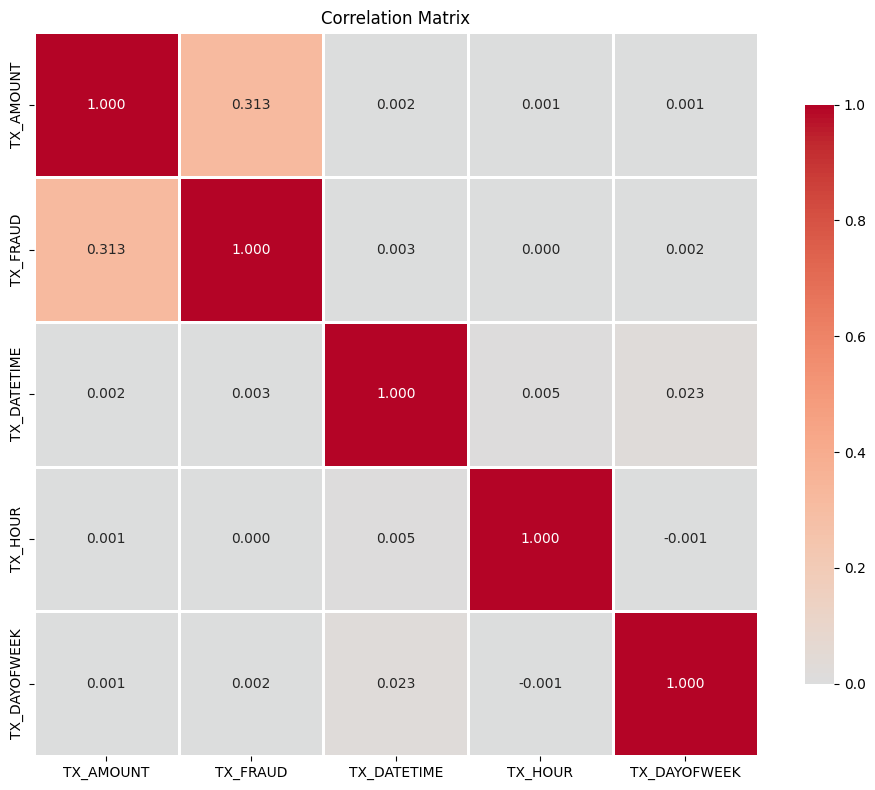

In [30]:
df_corr = df_time.select(
    *features
).toPandas()


correlation_matrix = df_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


## Correlation Analysis (Updated Feature Set)

This correlation matrix is used as a **sanity check** to examine linear relationships among core numerical and time-derived features.  
Given the nature of fraud detection, correlation values are interpreted cautiously, as many fraud patterns are non-linear.

### Key Observations

- **TX_AMOUNT vs TX_FRAUD**  
  The correlation coefficient remains at approximately **0.31**, indicating a **moderate positive linear relationship**.  
  This confirms that higher transaction amounts are associated with increased fraud risk and reinforces `TX_AMOUNT` as a core predictive feature.

- **Time-Derived Features vs TX_FRAUD**  
  Correlations between the fraud label and time-based features are near zero:
  - `TX_HOUR` ≈ 0.00  
  - `TX_DAYOFWEEK` ≈ 0.00  
  - Raw `TX_DATETIME` ≈ 0.00  

  These results indicate the absence of strong linear temporal effects. This is expected, as time-related fraud patterns are typically context-dependent and non-linear.

- **Inter-feature Correlations**  
  - `TX_HOUR` and `TX_DAYOFWEEK` show negligible correlation with each other and with transaction amount.
  - Raw timestamps exhibit minimal correlation with derived temporal features, suggesting no dominant global time trend in the dataset.

### Implications for Feature Engineering

- `TX_AMOUNT` should be retained as a **primary feature**, with appropriate transformation (e.g., log-scaling) to handle its heavy-tailed distribution.
- Time-based features (`TX_HOUR`, `TX_DAYOFWEEK`) should be treated as **secondary contextual features** rather than primary predictors.
- Raw timestamps (`TX_DATETIME`) should not be used directly in modeling and are better leveraged through engineered representations.

Overall, the updated correlation analysis aligns with earlier EDA findings and supports the chosen feature engineering strategy without indicating redundancy or leakage among features.
